In [70]:
import os
import torch
import xml.etree.ElementTree as ET
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pac

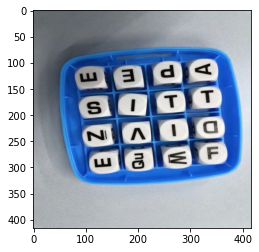

In [32]:
data_dir = "./boggle_boards/export"

# .jpg, .xml
_files = os.listdir(data_dir)
img = cv2.imread(os.path.join(data_dir, _files[2]))
plt.imshow(img)

In [184]:
def getImg(file, data_dir):
    return cv2.imread(os.path.join(data_dir, file))

def getBBox(file, data_dir):
    tree = ET.parse(os.path.join(data_dir, file))
    objects = tree.getroot().findall('object')
    bbox = [(
            o.find('name').text.strip(' \\'),
                 [
                    int(o.find('bndbox').find('xmin').text),
                    int(o.find('bndbox').find('xmax').text),
                    int(o.find('bndbox').find('ymin').text),
                    int(o.find('bndbox').find('ymax').text)
                    ] 
    ) for o in objects]
    return bbox

def getData(files, data_dir):
    out = {}
    for file in files:
        name = file.split('.')[0]
        if name not in out.keys():
            out[name] = {'bbox':None, 'img':[]}
        if '.xml' in file:
            bb = getBBox(file, data_dir)
            out[name]['bbox'] = bb
        elif '.jpg' in file:
            img = getImg(file, data_dir)
            out[name]['img'] = img
    return out
    
def plotBB(image_key, all_data):
    plt.axes()
    plt.imshow(all_data[image_key]['img'].reshape(416, 416, 3))
    for bb in all_data[image_key]['bbox']:
            rectangle = pac.Rectangle(
                (bb[1][0], bb[1][2]),
                abs(bb[1][1] - bb[1][0]),
                abs(bb[1][3] - bb[1][2]),
                fc = 'none',
                ec="red")
            plt.gca().add_patch(rectangle)
    plt.show()    

In [185]:
# get all the data
all_data = getData(_files, data_dir)


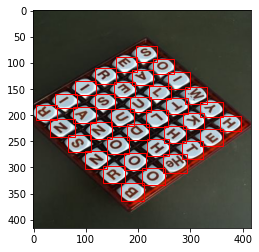

In [186]:
# plot some data with bounding boxes:
plotBB('04dcdbd29ee6e8077089edee1e924672', all_data)

In [187]:
all_data['fd4de77a2bfcf9f72c4dd49b91a65984']['bbox']

[('a', [293, 324, 111, 132]),
 ('e', [285, 312, 134, 156]),
 ('i', [276, 301, 158, 180]),
 ('u', [261, 293, 182, 207]),
 ('u', [215, 246, 176, 201]),
 ('qu', [231, 260, 153, 175]),
 ('o', [240, 270, 128, 149]),
 ('r', [253, 282, 107, 126]),
 ('a', [215, 242, 99, 119]),
 ('f', [200, 226, 121, 140]),
 ('d', [186, 218, 145, 164]),
 ('h', [174, 202, 96, 114]),
 ('h', [162, 188, 115, 134]),
 ('s', [142, 174, 137, 157]),
 ('h', [173, 203, 169, 190]),
 ('v', [127, 161, 162, 183])]

## make an object detection NNet
We have a regressor model for bounding boxes and a classification model for letters
We add the losses and run backprop

We need to develop a dataset class, dataloader class and the network.
We use this as a guide: https://pyimagesearch.com/2021/11/01/training-an-object-detector-from-scratch-in-pytorch/

In [206]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from itertools import chain

class CustomTensorDataset(Dataset):
    def __init__(self, tensors, transforms = None):
        self.tensors = tensors
        self.transforms = transforms

    def __getitem__(self, index):
        # get image, label and bounding box coords
        image = self.tensors[0][index]
        labels = self.tensors[1][index] 
        bboxes = self.tensors[2][index]

        # if more than 16 randomly select 16
        # if labels.size > 16:
        #     idx = choice(range(0, labels.size), 16)
        #     labels = labels[idx]
        #     bboxes = bboxes[idx]
        
        # not sure what this does? "transpose image such that its channel dimension becomes the leading one"
        image = image.permute(2, 0, 1)

        # if we transform the image by a rotation do we need to adjust the bounding box?
        if self.transforms:
            image = self.transforms(image)

        return (image, labels, bboxes)

    def __len__(self):
        return self.tensors[0].size(0)

In [194]:


# convert all_data to tensors
labels = []
bboxes = []
data = []
for obs in all_data.values():
    if len([k[0] for k in obs['bbox']]) >= 16:
        data.append(obs['img'])
        labels.append([k[0] for k in obs['bbox']][0:16])
        bboxes.append([k[1] for k in obs['bbox']][0:16])

le = LabelEncoder()
le.fit(np.unique(list(chain(*labels))))
labels = [le.transform(label_list) for label_list in labels]

In [215]:
split = train_test_split(
            data,
            labels,
            bboxes,
            test_size = 0.2,
            random_state = 42
            )    

# # split out into train / test
# perhaps just take the first 16 values for the labels and bounding boxes?
trainImages, testImages = torch.Tensor(split[0]), torch.Tensor(split[1])
trainLabels, testLabels = torch.Tensor(split[2]), torch.Tensor(split[3])
trainBBoxes, testBBoxes = torch.Tensor(split[4]), torch.Tensor(split[5])

# do I need these?
_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean = 0, std = 1)

])

In [216]:
BATCH_SIZE = 100

trainDS = CustomTensorDataset((trainImages, trainLabels, trainBBoxes), _transforms)
testDS = CustomTensorDataset((testImages, testLabels, testBBoxes), _transforms)
trainDL = DataLoader(trainDS, batch_size= BATCH_SIZE)
testDL = DataLoader(testDS, batch_size= BATCH_SIZE) # not sure why *2??

In [572]:
# make the network
class ObjectDetector(nn.Module):

    def __init__(self, num_objects):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 1, 16)
        self.pool = nn.MaxPool2d(8, 8)
        # bbox regressor
        self.fc1 = nn.Linear(2500, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 4 * num_objects)
        self.fc4 = nn.Linear(4 * num_objects, 4 * num_objects)

    def forward(self,x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.pool(x))
        x = torch.flatten(x, 1) # all dimensions except for batch
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x)) # try to teach model about bbox overlaps
        return x


class resnet_ObjectDetector(nn.Module):

    def __init__(self, base_mod, num_objects):
        super().__init__()
        self.base_mod = base_mod
        self.fc1 = nn.Linear(1000, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 4 * num_objects)
        self.fc4 = nn.Linear(4 * num_objects, 4 * num_objects)

    def forward(self,x):
        x = self.base_mod(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x)) # try to teach model about bbox overlaps
        return x

In [552]:
# create training function to play with hyperparams
def train(net, epochs, trainloader, criterion, optimizer, k = 10):
    # train the network
    results = dict()
    for epoch in range(epochs):

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels, bbox = data

            # zero the parameter gradients (still not sure what this is really?)
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.float())
            # print(outputs.size(), bbox.size(), torch.flatten(bbox, 1).size())
            loss = criterion(outputs, torch.flatten(bbox,1))
            loss.backward()
            optimizer.step()

            # print stats
            running_loss += loss.item()

        if epoch % k == 0: # print every k epochs
            print(f'{epoch + 1} loss: {running_loss:.3f}')

        results[epoch] = running_loss
        running_loss = 0.0 # reset at end of each epoch


    print('Finished Training')
    return results


In [553]:
import torch.optim as optim
# config

net = ObjectDetector(16)

criterion = nn.MSELoss() # for multi-class classification
optimizer = optim.Adam(net.parameters(), lr = 0.001, weight_decay=0.00001) 
model_results = train(net, 5, trainDL, criterion, optimizer, k = 1)

1 loss: 127651.758
2 loss: 127353.691
3 loss: 117869.168
4 loss: 82211.150
5 loss: 75384.076
Finished Training


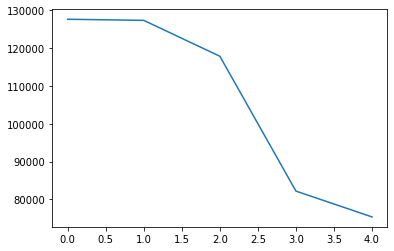

In [555]:
import pandas as pd
pd.Series(model_results).plot();
# model_results

In [582]:
# k = iter(testDS)
k = iter(trainDS)

In [669]:
def createBBoxPlot(bboxes, color = 'red'):
    """Sets out a series of bounding boxes and adds to an existing plot"""
    for bb in bboxes:
        rectangle = pac.Rectangle(
            (bb[0], bb[2]),
            abs(bb[1] - bb[0]),
            abs(bb[3] - bb[2]),
            fc = 'none',
            ec=color)
        plt.gca().add_patch(rectangle)

def bboxPlot(img, true_bb, pred_bb = False, prediction = False):
    """
    Creates an image plot with a base image and associated bounding boxes. If modelling, create predicted bboxes as well.
    """

    # plot the image
    plt.axes()
    plt.imshow(
        img.squeeze().detach().numpy().sum(axis = 0),
        cmap = 'Greys'
    )

    createBBoxPlot(true_bb)

    print(pred_bb.shape)
    print(pred_bb)
    if prediction:
        createBBoxPlot(pred_bb, 'green')
    
    plt.show()

def plotODResults(img, bbox, net = False, prediction = False):
    """
    takes image and bbox, network and prediction optional - but both must be present to run prediction.
    net is False, or a pytorch network
    """

    if prediction:
        pred_bbox = net(img)
        bboxPlot(
            img = img, 
            true_bb = bbox, 
            pred_bb = pred_bbox.detach().numpy().reshape(16, 4),
            prediction = prediction
            )
    else:
        bboxPlot(img, bbox)



(16, 4)
[[4.866402   0.726013   0.         0.        ]
 [0.         4.947888   1.4058318  3.7857006 ]
 [0.6799221  0.4680593  2.970842   0.0390114 ]
 [1.1731362  2.2759707  2.1071455  0.70481896]
 [1.25248    0.9907843  0.         1.917228  ]
 [0.9788398  0.         0.         0.        ]
 [1.9199314  1.2188495  4.471196   2.5366921 ]
 [2.5287957  0.90481246 0.         2.8491418 ]
 [0.21352263 0.         1.3060552  2.1357412 ]
 [0.         0.         2.7830708  4.40796   ]
 [3.1143186  1.4168547  1.0266954  0.5890533 ]
 [1.1787014  0.         0.73255616 0.        ]
 [0.         3.9595993  0.         0.6523952 ]
 [4.722089   0.798102   0.         0.        ]
 [4.080416   0.         1.1287259  0.        ]
 [0.1857478  0.         0.48306665 2.1300676 ]]
preddy!


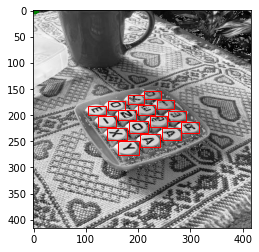

In [670]:
img, _, bbox = next(k)

plotODResults(img[None, : ], bbox, net, prediction = True)

In [619]:
img.detach().numpy().sum(axis = 0).shape

(416, 416)

In [577]:

img, _, bbox = next(k)
type(img)
pred = net(img)
pred_bb = pred.detach().numpy().reshape(16, 4)
plt.axes()
plt.imshow(img.detach().numpy().sum(axis = 0).reshape(416, 416), cmap = 'Greys')

# predictions
for bb in pred_bb:
        rectangle = pac.Rectangle(
            (bb[0], bb[2]),
            abs(bb[1] - bb[0]),
            abs(bb[3] - bb[2]),
            fc = 'none',
            ec="red")
        plt.gca().add_patch(rectangle)
# actual
for bb in bbox:
        rectangle2 = pac.Rectangle(
            (bb[0], bb[2]),
            abs(bb[1] - bb[0]),
            abs(bb[3] - bb[2]),
            fc = 'none',
            ec="green")
        plt.gca().add_patch(rectangle2)
plt.show()    

TypeError: conv2d() received an invalid combination of arguments - got (tuple, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!tuple!, !Parameter!, !NoneType!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!tuple!, !Parameter!, !NoneType!, !tuple!, !tuple!, !tuple!, int)


In [256]:
k = iter(trainDS)
image, label, bbox = next(k)

od = ObjectDetector(16)
res = od(image)
print(res)
# plt.imshow(res.detach().numpy().reshape(8, 8))

tensor([[0.1148, 0.1334, 0.0276, 0.0709, 0.0097, 0.0000, 0.3450, 0.0974, 0.0000,
         0.0889, 0.0000, 0.0000, 0.0311, 0.0000, 0.4364, 0.2964, 0.0000, 0.0000,
         0.0000, 0.0000, 1.0915, 0.2705, 0.3431, 0.0000, 0.1172, 0.3473, 0.0000,
         0.0000, 0.1433, 0.2279, 0.6779, 0.0000, 0.0000, 0.1145, 0.5016, 0.0318,
         0.1407, 0.0000, 0.0000, 0.5247, 0.0000, 0.1287, 0.0000, 0.0000, 0.0000,
         0.5387, 0.2347, 0.1974, 0.4336, 0.0000, 0.0000, 0.0000, 0.0000, 0.2718,
         0.0000, 0.0000, 0.0000, 0.0000, 0.2156, 0.1745, 0.0000, 0.0000, 0.0000,
         0.4327]], grad_fn=<ReluBackward0>)


In [579]:
from torchvision.models import resnet18

resnet = resnet18(weights = 'ResNet18_Weights.IMAGENET1K_V1')



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\61417/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:07<00:00, 6.66MB/s]


In [580]:
net = resnet_ObjectDetector(resnet, 16)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001, weight_decay=0.00001) 
model_results = train(net, 1, trainDL, criterion, optimizer, k = 1)

1 loss: 127184.695
Finished Training


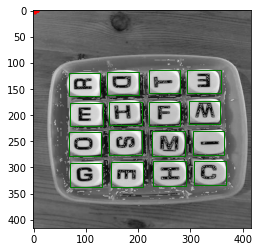

In [605]:
img, _, bbox = next(k)
type(img)

pred = net(img[None, :])
pred_bb = pred.detach().numpy().reshape(16, 4)
plt.axes()
plt.imshow(img.detach().numpy().sum(axis = 0).reshape(416, 416), cmap = 'Greys')

# predictions
for bb in pred_bb:
        rectangle = pac.Rectangle(
            (bb[0], bb[2]),
            abs(bb[1] - bb[0]),
            abs(bb[3] - bb[2]),
            fc = 'none',
            ec="red")
        plt.gca().add_patch(rectangle)
# actual
for bb in bbox:
        rectangle2 = pac.Rectangle(
            (bb[0], bb[2]),
            abs(bb[1] - bb[0]),
            abs(bb[3] - bb[2]),
            fc = 'none',
            ec="green")
        plt.gca().add_patch(rectangle2)
plt.show()    

